In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# Define data directories
train_dir = "data/train"
test_dir  = "data/test"

In [3]:
# Define transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
# Load datasets
image_datasets = {
    'train': datasets.ImageFolder(train_dir, data_transforms['train']),
    'test': datasets.ImageFolder(test_dir, data_transforms['test'])
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=128, shuffle=True, num_workers=4),
    'test': DataLoader(image_datasets['test'], batch_size=128, shuffle=False, num_workers=4)
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes


In [5]:
# Load pre-trained ResNet50 model
model = models.resnet50(pretrained=True)

# Freeze model parameters
for param in model.parameters():
    param.requires_grad = False


/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# Modify the final layers to improve learning
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, len(class_names))
)

In [7]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.fc.parameters(), lr=0.0001, weight_decay=5e-5)

# Check for GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [8]:
# Training function
def train_model(model, criterion, optimizer, num_epochs=30):
    best_acc = 0.0
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and testing phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), 'plant_disease_model_best.pth')

        print()
    return model


In [9]:
# Train the model
model = train_model(model, criterion, optimizer, num_epochs=30)

# Save the final trained model
torch.save(model.state_dict(), 'plant_disease_model_final.pth')


Epoch 0/29
----------
train Loss: 3.2754 Acc: 0.0766
test Loss: 3.2274 Acc: 0.1780

Epoch 1/29
----------
train Loss: 2.9896 Acc: 0.1914
test Loss: 2.8816 Acc: 0.2839

Epoch 2/29
----------
train Loss: 2.7398 Acc: 0.2872
test Loss: 2.6960 Acc: 0.3220

Epoch 3/29
----------
train Loss: 2.5964 Acc: 0.3189
test Loss: 2.5790 Acc: 0.3347

Epoch 4/29
----------
train Loss: 2.4485 Acc: 0.3622
test Loss: 2.5040 Acc: 0.3602

Epoch 5/29
----------
train Loss: 2.3347 Acc: 0.3673
test Loss: 2.4337 Acc: 0.3602

Epoch 6/29
----------
train Loss: 2.2501 Acc: 0.4020
test Loss: 2.3620 Acc: 0.3856

Epoch 7/29
----------
train Loss: 2.1760 Acc: 0.4037
test Loss: 2.3192 Acc: 0.3686

Epoch 8/29
----------
train Loss: 2.1026 Acc: 0.4289
test Loss: 2.2602 Acc: 0.3814

Epoch 9/29
----------
train Loss: 2.0230 Acc: 0.4533
test Loss: 2.2207 Acc: 0.3941

Epoch 10/29
----------
train Loss: 1.9658 Acc: 0.4683
test Loss: 2.1830 Acc: 0.3983

Epoch 11/29
----------
train Loss: 1.9191 Acc: 0.4692
test Loss: 2.1535 Acc

In [10]:
# Function to visualize some predictions
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                img = np.clip(img, 0, 1)
                plt.imshow(img)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


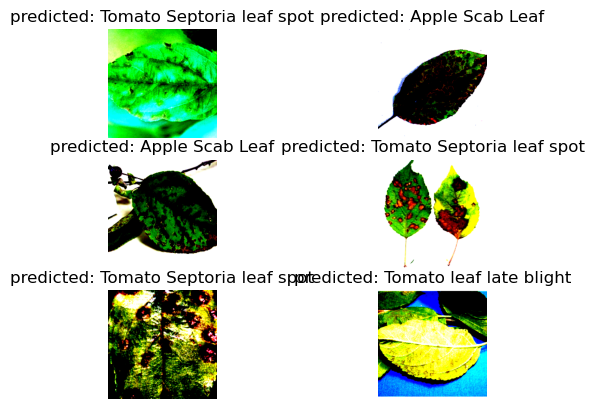

In [11]:
# Visualize the model predictions
visualize_model(model)
plt.show()